1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [41]:
# Load data
import pandas as pd
import pylab as plt
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
import random
import json
import numpy as np
import statsmodels.formula.api as sm
pd.set_option('display.max_columns', 500)
%matplotlib inline

df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [42]:
df = df.replace({'default':{'No':0, 'Yes':1}})
df = df.replace({'student':{'No':0, 'Yes':1}})
df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

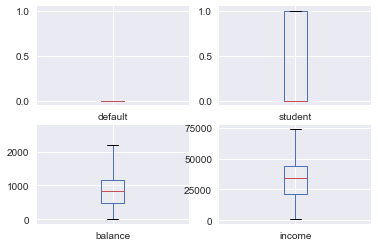

In [43]:
import matplotlib.pyplot as plt

#boxplots
plt.subplot(2,2,1)
df.boxplot(column = ['default'])
plt.subplot(2,2,2)
df.boxplot(column = ['student'])
plt.subplot(2,2,3)
df.boxplot(column = ['balance'])
plt.subplot(2,2,4)
df.boxplot(column = ['income'])


In [44]:
test = df.drop(['student','balance','income'], axis = 1)
df.groupby('default').count()


,student,balance,income
default,,,
0,9667,9667,9667
1,333,333,333


The boxplots show that there are significantly more '0' values for default than '1' values. The '1' values are deemed outliers.

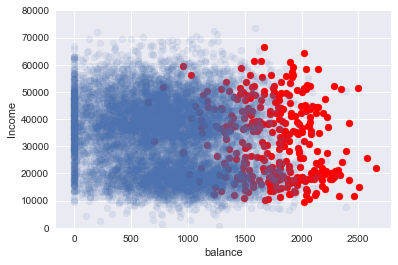

In [59]:
#Scatter plot
plt.figure()

plt.ylim(0,80000)
plt.scatter(df.loc[df['default'] == 1, 'balance'] , df.loc[df['default'] == 1, 'income'] , color='r', alpha = 1)
plt.scatter(df.loc[df['default'] == 0, 'balance'] , df.loc[df['default'] == 0, 'income'], alpha = 0.1)


plt.ylabel('Income')
plt.xlabel('balance')

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

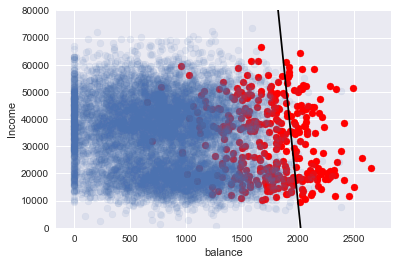

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#split data into train test
X = df.drop(['default', 'student'],axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#fit logistic regression curve
clf = LogisticRegression(penalty='l1', C=1)    
clf.fit(X_train, y_train)

#Scatter plot
plt.figure()

plt.ylim(0,80000)
plt.scatter(df.loc[df['default'] == 1, 'balance'] , df.loc[df['default'] == 1, 'income'] , color='r', alpha = 1)
plt.scatter(df.loc[df['default'] == 0, 'balance'] , df.loc[df['default'] == 0, 'income'], alpha = 0.1)


plt.ylabel('Income')
plt.xlabel('balance')

#decision boundary
#vars
w = clf.coef_[0]
m = -w[0] / w[1]
b = clf.intercept_[0]

#plotting
xx = np.linspace(0, 2700)
yy = m * xx - b / w[1] 
plt.plot(xx, yy, color = 'k')

Coefficients: [[  5.37470142e-03   1.35298918e-05]]
Training accuracy: 0.973875
Testing accuracy: 0.971


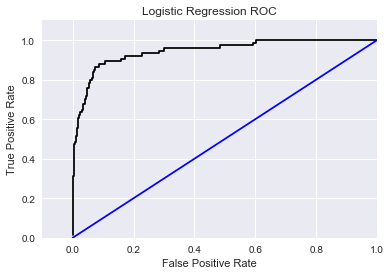


 Area under the curve: 0.943819988213


In [82]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

#characterize fit
print('Coefficients:', clf.coef_)
print('Training accuracy:', clf.score(X_train, y_train))
print('Testing accuracy:', clf.score(X_test, y_test))

pred = clf.predict_proba(X_test)

#roc curve parameters (false positive rate, true positive rate)
fpr, tpr, thresh = roc_curve(y_test, pred[:,1])

plt.figure()
plt.plot(fpr, tpr, color='k')
plt.plot([0, 1], [0, 1], color='b')
plt.xlim([-0.1, 1])
plt.ylim([0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC')
plt.show()
         
         
print('\n Area under the curve:',auc(fpr, tpr))

The area under the ROC curve is >94.3%, meaning the logistic regression curve does a very good job of determining whether someone will default. 

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

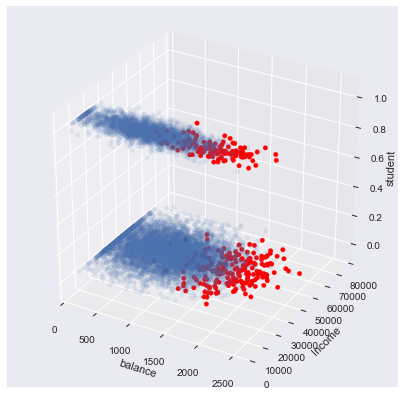

In [90]:
from mpl_toolkits.mplot3d import Axes3D

#Scatter plot
fig = plt.figure(figsize=(7,7))

#set up axes
ax = fig.add_subplot(111, projection='3d')
plt.xlim(0,2700)
plt.ylim(0,80000)
ax.set_zlim(-0.1,1.1)


ax.scatter(df.loc[df['default'] == 1, 'balance'] , df.loc[df['default'] == 1, 'income'] , df.loc[df['default'] == 1, 'student'] , color='r', alpha = 1)
ax.scatter(df.loc[df['default'] == 0, 'balance'] , df.loc[df['default'] == 0, 'income'],  df.loc[df['default'] == 0, 'student'] , alpha = 0.1)

plt.ylabel('Income')
plt.xlabel('balance')
ax.set_zlabel('student')


Coefficients: [ -8.99638144e-03   1.29642575e-04   8.34744940e-08]
Training accuracy: 0.121282951649
Testing accuracy: 0.132415694538


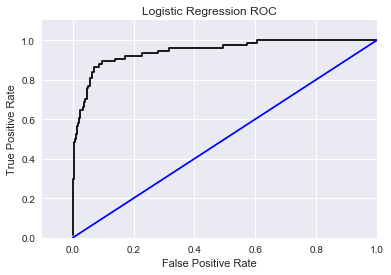

Area under the curve of the ROC: 0.944472509893


In [91]:
from sklearn.linear_model import Ridge

#split data into train test (include students in X)
X = df.drop(['default'],axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Ridge regression
rr = Ridge(alpha=0.001)
rr.fit(X_train, y_train)
pred = rr.predict(X_test)

#characterize fit
print('Coefficients:', rr.coef_)
print('Training accuracy:', rr.score(X_train, y_train))
print('Testing accuracy:', rr.score(X_test, y_test))

#roc curve parameters (false positive rate, true positive rate)
fpr, tpr, thres = roc_curve(y_test, pred)

plt.figure()
plt.plot(fpr, tpr, color='k')
plt.plot([0, 1], [0, 1], color='b')
plt.xlim([-0.1, 1])
plt.ylim([0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC')
plt.show()

print('Area under the curve of the ROC:',auc(fpr, tpr))

Incorporating the student variable and performing ridge regression to create a classification boundary improved the ROC by 0.06%. Although very small, there is a slight improvement, suggesting that the student variable may be relevant in predicting whether someone will default.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

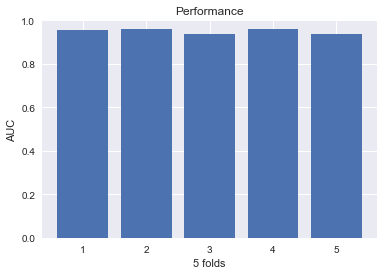

AUC mean:  0.949177942422
AUC standard deviation:  0.0107112380662


In [93]:
from sklearn.cross_validation import cross_val_score 

#use auc as criteria and perform 5 fold cross validation
scores = cross_val_score(rr, X, y, cv=5, scoring='roc_auc')

plt.ylim([0,1])
plt.xlabel('5 folds')
plt.ylabel('AUC')
plt.title('Performance')
plt.bar(range(1,6),scores)
plt.show()

print('AUC mean: ',scores.mean())
print('AUC standard deviation: ',scores.std())

We see that the mean AUC is very high (>94.9%) and the standard deviation of the AUC is very small (~0.01). This suggests that our training sets did not produce too much bias and that our classification method is robust.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

AUC when using logistic regression:   0.944472509893
AUC when using decision tree:  0.906871825096


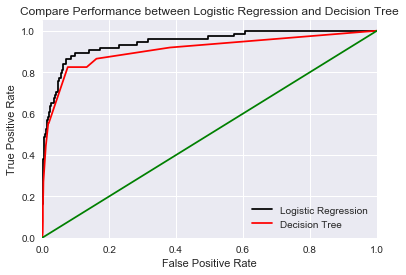

In [98]:
from sklearn import tree

#Compare performance by plotting ROC curves

#Log Reg
pred = rr.predict(X_test)

#characterize fit
fpr1, tpr1, thres1 = roc_curve(y_test, pred)
print('AUC when using logistic regression:  ',auc(fpr1, tpr1))

plt.figure()
plt.plot(fpr1, tpr1, color='k', label='Logistic Regression')

#decision tree classifier
#initial depth = 5
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)

clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)

#characterize fit
fpr2, tpr2, thres2 = roc_curve(y_test, pred[:,1])
print('AUC when using decision tree: ',auc(fpr2, tpr2))

plt.plot(fpr2, tpr2, color='r', label='Decision Tree')
plt.plot([0, 1], [0, 1], color='g')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Compare Performance between Logistic Regression and Decision Tree')
plt.legend(loc="lower right")
plt.show()

We see that the AUC is greater when using logistic regression vs when using a decision tree. This suggests that this data is better suited for classification using logistic regression.

In [ ]:
#plotting decision tree
from sklearn import tree
import graphviz

clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)

data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=X.columns.values,
                         filled=True, rounded=True,  
                         special_characters=True) 

Graph = graphviz.Source(data)

8) Find the optimal decision tree depth and compute the AUC ROC. 

O Decision Tree Depth:  4


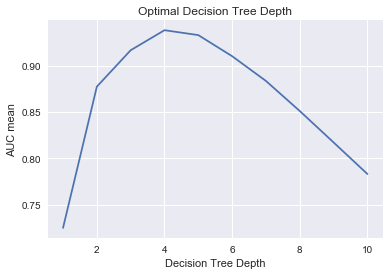

In [99]:
from sklearn.model_selection import train_test_split

#find the mean area under the curve using 5 fold cross validation
#asses tree depths of 1-10 and determine which works best to classify the data
scores=[]
depths = range(1,11)

for n in depths:
    regr = tree.DecisionTreeClassifier(max_depth=n)
    scores.append(cross_val_score(regr, X, y, cv=5, scoring='roc_auc').mean())

plt.figure()
plt.plot(depths, scores)
plt.xlabel('Decision Tree Depth')
plt.ylabel('AUC mean')
plt.title('Optimal Decision Tree Depth')
od = scores.index(max(scores))+1

print('O Decision Tree Depth: ',od)


Area under the curve of the ROC: 0.93473379922


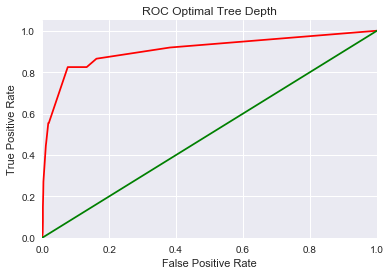

In [100]:

#AUC ROC of optimal depth

regr = tree.DecisionTreeClassifier(max_depth=od)
regr.fit(X_train, y_train)
pred = regr.predict_proba(X_test)

#characterize fit
fpr, tpr, thres = roc_curve(y_test, pred[:,1])
print('Area under the curve of the ROC:',auc(fpr, tpr))


plt.plot(fpr2, tpr2, color='r', label='Decision Tree')
plt.plot([0, 1], [0, 1], color='g')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Optimal Tree Depth')
plt.show()

By calculating the mean AUC using 5 fold cross validation, we characterized the quality of each depth value of the decision tree. The optimal depth (highest mean AUC of ROC) was 4, meaning that a decision tree with a depth of 4 is most adept at classifying whether or not someone will default.